In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [7]:
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

featdict = {'freq':['Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew','PSD_kur'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ','Sen_X','Sen_Y','Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean','jerk_std','jerk_skew','jerk_kur'],
            'mag' :['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag','Sen_mag']}

def fix_feature_names(features):
    feats = features.copy()
    if feats[0][-3:] != 'acc':
        featlen = len(feats)
        for f in range(featlen):
            feats.append(feats[f] + ' gyr')
        for f in range(featlen):
            feats[f] = feats[f] + ' acc'
    return feats

featdictsensors = {}

for featgroup in featdict.keys():
    feats = fix_feature_names(featdict[featgroup])
    featdictsensors[featgroup] = feats

In [8]:
lst = featdict.keys()
combs = []
for i in range(len(lst)):
    els = [list(x) for x in combinations(lst, i+1)]
    combs.extend(els)

combs

[['freq'],
 ['time'],
 ['corr'],
 ['jerk'],
 ['mag'],
 ['freq', 'time'],
 ['freq', 'corr'],
 ['freq', 'jerk'],
 ['freq', 'mag'],
 ['time', 'corr'],
 ['time', 'jerk'],
 ['time', 'mag'],
 ['corr', 'jerk'],
 ['corr', 'mag'],
 ['jerk', 'mag'],
 ['freq', 'time', 'corr'],
 ['freq', 'time', 'jerk'],
 ['freq', 'time', 'mag'],
 ['freq', 'corr', 'jerk'],
 ['freq', 'corr', 'mag'],
 ['freq', 'jerk', 'mag'],
 ['time', 'corr', 'jerk'],
 ['time', 'corr', 'mag'],
 ['time', 'jerk', 'mag'],
 ['corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk'],
 ['freq', 'time', 'corr', 'mag'],
 ['freq', 'time', 'jerk', 'mag'],
 ['freq', 'corr', 'jerk', 'mag'],
 ['time', 'corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk', 'mag']]

In [14]:
datadict = {'Tremor':pd.read_csv('Y:\\CIS-PD Study\\Downsample\\Accel Data 62.5Hz.csv',index_col=0),
            'Bradykinesia':pd.read_csv('Y:\\CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5HZ.csv',index_col=0)}

In [15]:
t1 = time.time()
results = {}

for symptom in ['Tremor','Bradykinesia']:
    
    results[symptom] = {}
    
    data = datadict[symptom]
    
    results[symptom]['Binary'] = {}
    binary_res_all = pd.DataFrame()
    binary_res_groups = []
        
    results[symptom]['Multiclass'] = {}
    multi_res_all = pd.DataFrame()
    multi_res_groups = pd.DataFrame()
        
    results[symptom]['Regressor'] = {}
    regress_res_all = pd.DataFrame()
    regress_res_groups = pd.DataFrame()
    
    for comb in combs:

        feat_cols = []
        comb_group = ''

        for features_set in comb:

            comb_group += features_set[0]
            if symptom == 'Tremor':
                feat_cols = feat_cols + featdict[features_set]
            else:
                feat_cols = feat_cols + featdictsensors[features_set]

        data_comb = data[info + feat_cols]

        Data = data_comb.copy() #original unmodified dataframe
        Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
        Data=Data.reset_index(drop=True) #reset index

        X = Data.iloc[:,5:].values()
        groups = Data.Subject.values()
        fnames = Data.iloc[:,5:].columns.values
        
        #Binary
        
        y = ((Data[symptom]>0)).values.astype(int)
        
        model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        model = list(zip(model,model_name))

        res,res_group = LOSOCV(Data,X,y,groups,model)
        res['Combination'] = comb_group
        binary_res_all = pd.concat((binary_res_all,res))
        binary_res_groups.append(res_group)
        
        results[symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[symptom]['Binary']['res_groups'] = binary_res_groups
        
        #Multiple Classes
        
        y = Data[symptom].values.astype(int)

        model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        model = list(zip(model,model_name))
        
        res,res_group = LOSOMultiClass(Data,X,y,groups,model)
        res['Combination'] = comb_group
        multi_res_groups = pd.concat((multi_res_groups,res))
        R = pd.DataFrame()
        R['RMS'] = [np.nanmean(multi_res_groups[multi_res_groups.Combination==comb_group]['RMS'])]
        R['Model'] = ['Random Forest']
        R['Combination'] = [comb_group]
        multi_res_all = pd.concat([multi_res_all,R])
        
        results[symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[symptom]['Multiclass']['res_groups'] = multi_res_groups
        
        #Regressor
        
        y = Data[symptom].values.astype(int) #target 

        model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        model = list(zip(model,model_name))
        
        res,res_group = LOSOMultiClass(Data,X,y,groups,model)
        res['Combination'] = comb_group
        regress_res_groups = pd.concat((regress_res_groups,res))
        R = pd.DataFrame()
        R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups.Combination==comb_group]['RMS'])]
        R['Model'] = ['Random Forest'] 
        R['Combination'] = [comb_group]
        regress_res_all = pd.concat([regress_res_all,R])
        
        results[symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
        results[symptom]['Regressor']['res_groups'] = regress_res_groups

print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest
Elapsed time = 436.560 min


In [29]:
results['Tremor']['Binary']['res_all']

,model,f1,auprc,auroc,Combination
0,Random Forest,0.204243,0.371307,0.591132,f
1,Random Forest,0.322554,0.464493,0.702262,t
2,Random Forest,0.242927,0.412936,0.604964,c
3,Random Forest,0.288830,0.443245,0.638681,j
4,Random Forest,0.344929,0.463583,0.700593,m
5,Random Forest,0.327615,0.462666,0.697709,ft
6,Random Forest,0.232828,0.435210,0.630975,fc
7,Random Forest,0.327562,0.474013,0.683651,fj
8,Random Forest,0.337781,0.478522,0.705855,fm
9,Random Forest,0.336037,0.476393,0.707676,tc


In [50]:
def barplotFeatures(results,symptom,classifier):
    if 'RMS' in results[symptom][classifier]['res_groups']:
        groups = results[symptom][classifier]['res_groups']['Combination']
        RMS = results[symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
    else:
        groups = results[symptom][classifier]['res_all']['Combination'].values
        aucdf = pd.DataFrame()
        data = results[symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Feature Sets')
    plt.title('Effect of Feature Combinations on %s Model Performance: %s'%(classifier,symptom))
    print('f: frequency')
    print('t: time')
    print('c: correlation')
    print('j: jerk')
    print('m: mag')
    #print(results[symptom][classifier]['res_all'])

In [62]:
def stats_tests(results,symptom,classifier):
    df = pd.DataFrame()
    comblist = list(results[symptom][classifier]['res_all']['Combination'])
    if 'RMS' in results[symptom][classifier]['res_groups']:
        for comb in comblist:
            df[comb] = results[symptom][classifier]['res_groups'][results[symptom][classifier]['res_groups']['Combination']==comb]['RMS']
        df = df.reset_index(drop=True)
    else:
        for i in range(len(comblist)):
            comb = comblist[i]
            df[comb] = pd.Series(results[symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['f'].isnull()].reset_index(drop=True)
        
    grand_mean = np.mean(df.mean())
    sub_means = np.mean(df,axis=1)
    col_means = np.mean(df,axis=0)
    n = len(df)
    k = len(df.columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df)]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    print()
    print('Repeated Measures ANOVA')
    print('pvalue: ' + str(stats.f.sf(F,dfbw,dferror)))
    print()
    
    for comb in ['f','c','j','m','ftcjm']:
        p = stats.ttest_rel(df['t'],df[comb])
        print('t, %s'%comb)
        print(p)

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 4.913549054689126e-29

t, f
Ttest_relResult(statistic=4.2035909103983515, pvalue=0.001476622004781889)
t, c
Ttest_relResult(statistic=4.331937912344373, pvalue=0.0011907039994029289)
t, j
Ttest_relResult(statistic=3.2172912393211206, pvalue=0.0081984814242555)
t, m
Ttest_relResult(statistic=0.11389405124049994, pvalue=0.9113739746585954)
t, ftcjm
Ttest_relResult(statistic=-1.8050029230751985, pvalue=0.098489939742494)


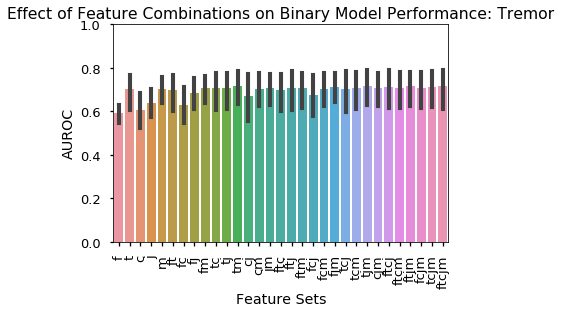

In [63]:
barplotFeatures(results,'Tremor','Binary')
stats_tests(results,'Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 8.906097194895458e-69

t, f
Ttest_relResult(statistic=-1.8519634850636202, pvalue=0.08878040347258559)
t, c
Ttest_relResult(statistic=-1.192100021810946, pvalue=0.2562636648113987)
t, j
Ttest_relResult(statistic=-4.788996541724317, pvalue=0.00044173460932541076)
t, m
Ttest_relResult(statistic=-12.799657374622509, pvalue=2.349230892560345e-08)
t, ftcjm
Ttest_relResult(statistic=5.893765293080565, pvalue=7.323159141508633e-05)


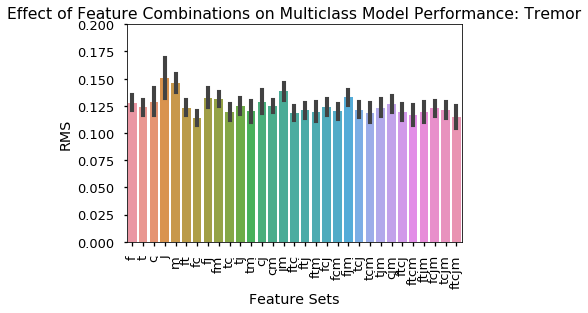

In [64]:
barplotFeatures(results,'Tremor','Multiclass')
stats_tests(results,'Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 5.218660030331608e-46

t, f
Ttest_relResult(statistic=-5.264782214136245, pvalue=0.0001995062794932725)
t, c
Ttest_relResult(statistic=-3.1102442461534, pvalue=0.0090167506905261)
t, j
Ttest_relResult(statistic=-3.6375644060238104, pvalue=0.0034032115250124556)
t, m
Ttest_relResult(statistic=-13.468774332178011, pvalue=1.3226097601125775e-08)
t, ftcjm
Ttest_relResult(statistic=7.7068055584924355, pvalue=5.49885521147907e-06)


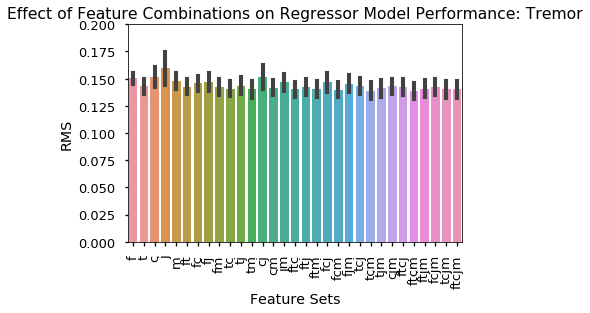

In [65]:
barplotFeatures(results,'Tremor','Regressor')
stats_tests(results,'Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 1.0464594904077247e-23

t, f
Ttest_relResult(statistic=2.9878799045333455, pvalue=0.011318786661141635)
t, c
Ttest_relResult(statistic=4.613935279434423, pvalue=0.0005964012838987744)
t, j
Ttest_relResult(statistic=3.715166318015009, pvalue=0.0029528158425049526)
t, m
Ttest_relResult(statistic=2.4779628117665853, pvalue=0.029066385231013094)
t, ftcjm
Ttest_relResult(statistic=1.6025145159401066, pvalue=0.13502241540277649)


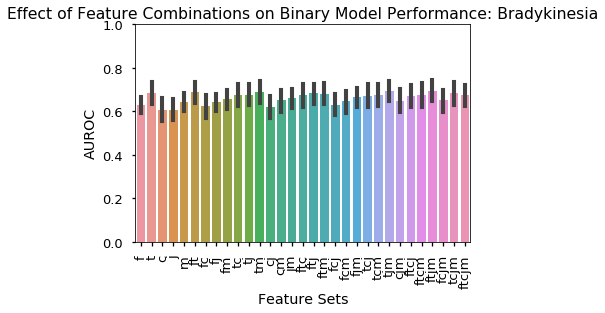

In [66]:
barplotFeatures(results,'Bradykinesia','Binary')
stats_tests(results,'Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 5.480002033406227e-35

t, f
Ttest_relResult(statistic=-0.576333604802221, pvalue=0.5750406795852849)
t, c
Ttest_relResult(statistic=-2.1474092591467677, pvalue=0.05288729379722288)
t, j
Ttest_relResult(statistic=-0.28160610576426914, pvalue=0.7830428777827411)
t, m
Ttest_relResult(statistic=-6.837387899663625, pvalue=1.8042606007211952e-05)
t, ftcjm
Ttest_relResult(statistic=2.408604035271517, pvalue=0.03299670572989949)


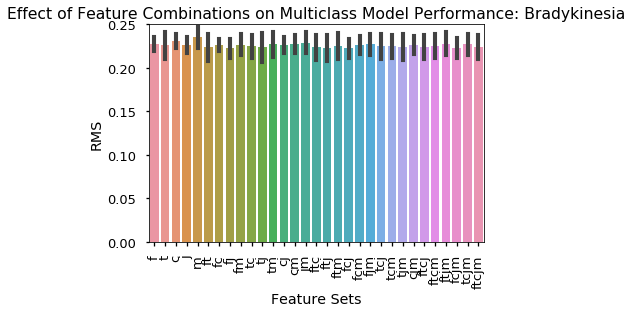

In [67]:
barplotFeatures(results,'Bradykinesia','Multiclass')
stats_tests(results,'Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
pvalue: 1.4259586406033631e-21

t, f
Ttest_relResult(statistic=-0.4177491002034164, pvalue=0.683508259617359)
t, c
Ttest_relResult(statistic=-3.233930156256504, pvalue=0.007166868894557001)
t, j
Ttest_relResult(statistic=0.7732908044285077, pvalue=0.4543140633714341)
t, m
Ttest_relResult(statistic=-3.9742215250187165, pvalue=0.001845401207614302)
t, ftcjm
Ttest_relResult(statistic=8.155921998435492, pvalue=3.0839935042733542e-06)


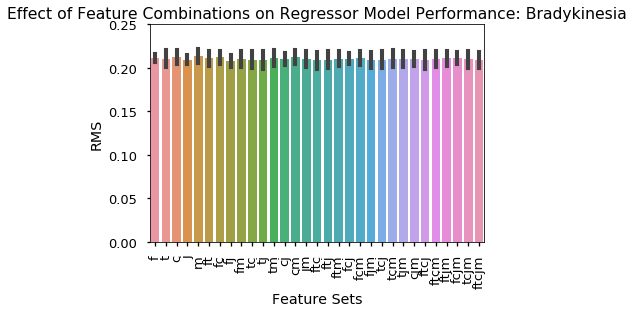

In [68]:
barplotFeatures(results,'Bradykinesia','Regressor')
stats_tests(results,'Bradykinesia','Regressor')